# Create biweekly renku datasets from `climetlab-s2s-ai-challenge`

Goal:

- Create biweekly renku datasets from [`climatelab-s2s-ai-challenge`](https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge).
- These renku datasets are then used in notebooks:
    - `ML_train_and_predict.ipynb` to train the ML model and do ML-based predictions
    - `RPSS_verification.ipynb` to calculate RPSS of the ML model

Requirements:
- [`climetlab`](https://github.com/ecmwf/climetlab)
- [`climatelab-s2s-ai-challenge`](https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge)
- S2S and CPC observations uploaded on [European Weather Cloud (EWC)](https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/training-input/0.3.0/netcdf/index.html)

Output: [renku datasets](https://renku-python.readthedocs.io/en/latest/commands.html#module-renku.cli.dataset)
- observations
    - deterministic:
        - `hindcast-like-observations_2000-2019_biweekly_deterministic`
        - `forecast-like-observations_2020_biweekly_deterministic`
    - edges:
        - `hindcast-like-observations_2000-2019_biweekly_tercile-edges`
    - probabilistic:
        - `hindcast-like-observations_2000-2019_biweekly_terciled`
        - `forecast-like-observations_2020_biweekly_terciled`
- forecasts/hindcasts
    - deterministic:
        - `ecmwf_forecast-input_2020_biweekly_deterministic`
        - `ecmwf_hindcast-input_2000-2019_biweekly_deterministic`
    - more models could be added
- benchmark:
    - probabilistic:
        - `ecmwf_recalibrated_benchmark_2020_biweekly_terciled` (missing)

In [1]:
# use most recent version of climetlab-s2s-ai-challenge
#!pip install git+https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge.git

In [1]:
import climetlab as cml
import matplotlib.pyplot as plt
import xarray as xr
import xskillscore as xs
import pandas as pd

xr.set_options(keep_attrs=True)
xr.set_options(display_style='text')

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/climetlab/plotting/drivers/magics/actions.py:36: UserWarning: Magics library could not be found
  warnings.warn(str(e))


In [3]:
# caching path for climetlab
cache_path = "/work/mh0727/m300524/S2S_AI/cache" # set your own path
cml.settings.set("cache-directory", cache_path)
cache_path = "../data"

In [4]:
import climetlab_s2s_ai_challenge
print(f'Climetlab version : {cml.__version__}')
print(f'Climetlab-s2s-ai-challenge plugin version : {climetlab_s2s_ai_challenge.__version__}')

Climetlab version : 0.5.6
Climetlab-s2s-ai-challenge plugin version : 0.4.17


# Download and cache

Download all files for the observations, forecast and hindcast.

In [4]:
dates = xr.cftime_range(start='20200102',freq='7D', periods=53).strftime('%Y%m%d').to_list()
dates[:5]

['20200102', '20200109', '20200116', '20200123', '20200130']

## observations `output-reference`

In [13]:
obs_dataset_labels = ['training-output-reference','test-output-reference'] # ML community
# equiv to
obs_dataset_labels = ['hindcast-like-observations','forecast-like-observations'] # NWP community

In [14]:
varlist_obs = ['tp','t2m']

In [ ]:
%%time
# takes 5h for one model
for v in varlist_obs:
    for d in dates:
        for ds in obs_dataset_labels:
            print(ds,v,d)
            # only netcdf, no choice
            cml.load_dataset(f"s2s-ai-challenge-{ds}", date=d, parameter=v).to_xarray()

## hindcast and forecast `input`

In [15]:
forecast_dataset_labels = ['training-input','test-input'] # ML community
# equiv to
forecast_dataset_labels = ['hindcast-input','forecast-input'] # NWP community

In [16]:
varlist_forecast = ['tp','t2m']

In [17]:
model_list = ['ecmwf']

In [27]:
%%time
# takes 4-5h for one model
for model in model_list:
    for v in varlist_forecast:
        for d in dates:
            for ds in forecast_dataset_labels:
                print(ds,v,d)
                # take netcdf format
                cml.load_dataset(f"s2s-ai-challenge-{ds}", origin=model, date=d, parameter=v, format='netcdf').to_xarray()

# create bi-weekly aggregates

In [7]:
from scripts import add_valid_time_from_forecast_reference_time_and_lead_time

In [19]:
w34 = [pd.Timedelta(f'{i} d') for i in range(14,28)]
w34 = xr.DataArray(w34,dims='lead_time', coords={'lead_time':w34})
w34

<xarray.DataArray (lead_time: 14)>
array([1209600000000000, 1296000000000000, 1382400000000000,
       1468800000000000, 1555200000000000, 1641600000000000,
       1728000000000000, 1814400000000000, 1900800000000000,
       1987200000000000, 2073600000000000, 2160000000000000,
       2246400000000000, 2332800000000000], dtype='timedelta64[ns]')
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 14 days 15 days ... 26 days 27 days

In [20]:
w56 = [pd.Timedelta(f'{i} d') for i in range(28,42)]
w56 = xr.DataArray(w56,dims='lead_time', coords={'lead_time':w56})
w56

<xarray.DataArray (lead_time: 14)>
array([2419200000000000, 2505600000000000, 2592000000000000,
       2678400000000000, 2764800000000000, 2851200000000000,
       2937600000000000, 3024000000000000, 3110400000000000,
       3196800000000000, 3283200000000000, 3369600000000000,
       3456000000000000, 3542400000000000], dtype='timedelta64[ns]')
Coordinates:
  * lead_time  (lead_time) timedelta64[ns] 28 days 29 days ... 40 days 41 days

In [21]:
# starting dates forecast_time in 2020
dates = xr.cftime_range(start='20200102',freq='7D', periods=53).strftime('%Y%m%d').to_list()

biweekly_lead = [pd.Timedelta(f"{i} d") for i in [14, 28]] # take first day of biweekly average 
# alternative: new lead_time coordinate: use 21 35 as mid points of week 3-4 and week 5-6

In [22]:
model = 'ecmwf'
for dsl in forecast_dataset_labels + obs_dataset_labels: # dataset labels
    for v in varlist_forecast:
        print(dsl,v)
        ds = []
        for d in dates:
            if 'input' in dsl:
                # just ecmwf model for now
                ds2 = cml.load_dataset(f"s2s-ai-challenge-{dsl}", origin=model, date=d, parameter=v, format='netcdf').to_xarray()
            elif 'observation' in dsl: # obs only netcdf, no choice
                ds2 = cml.load_dataset(f"s2s-ai-challenge-{dsl}", date=d, parameter=v).to_xarray().chunk()
            if v == 't2m': # biweekly mean
                d34 = ds2.sel(lead_time=w34).mean('lead_time')
                d56 = ds2.sel(lead_time=w56).mean('lead_time')
                ds2 = xr.concat([d34,d56],'lead_time').assign_coords(lead_time=biweekly_lead)
            elif v=='tp': # biweekly sum
                d34 = ds2.sel(lead_time=pd.Timedelta("27 d")) - ds2.sel(lead_time=pd.Timedelta("13 d")) # tp from day 14 to day 27
                d56 = ds2.sel(lead_time=pd.Timedelta("41 d")) - ds2.sel(lead_time=pd.Timedelta("27 d")) # tp from day 28 to day 42
                ds2 = xr.concat([d34,d56],'lead_time').assign_coords(lead_time=biweekly_lead)
            ds.append(ds2.chunk({'forecast_time':1}))
        
        # sort forecast_time
        ds = xr.concat(ds, 'forecast_time').sortby('forecast_time')
        ds = add_valid_time_from_forecast_reference_time_and_lead_time(ds)
        ds.lead_time.attrs['comment'] = 'lead_time describes bi-weekly aggregates. The pd.Timedelta corresponds to the first day of the '

        # first run on tp and add t2m to that dataset
        if v == 'tp':
            ds_ = ds.copy()
        elif v=='t2m':
            ds_[v] = ds[v]
            ds = ds_

    if 'test' in dsl:
        ds = ds.chunk('auto')
    else:
        ds = ds.chunk({'forecast_time':12,'lead_time':-1,'longitude':'auto','latitude':'auto'}) # 3 month init chunk
    
    if 'hindcast' in dsl:
        time = '2000-2019'
        if 'input' in dsl:
            name = f'{model}_{dsl}'
        elif 'observations':
            name = dsl
        
    elif 'forecast' in dsl:
        time = '2020'
        if 'input' in dsl:
            name = f'{model}_{dsl}'
        elif 'observations':
            name = dsl
    else:
        assert False
    
    # pattern: {model if applies _}{observations/forecast/hindcast}_{time}_biweekly_deterministic.zarr
    zp = f'{cache_path}/{name}_{time}_biweekly_deterministic.zarr'
    print(f'save to: {zp}')
    ds.to_zarr(zp, consolidated=True, mode='w')

hindcast-input tp
By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data. 


hindcast-input t2m
save to: ../data/ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr
forecast-input tp
By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data. 
forecast-input t2m
save to: ../data/ecmwf_forecast-input_2020_biweekly_deterministic.zarr
hindcast-like-observations tp
By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data.  This dataset has been dowloaded from IRIDL. By downloading this data you also agree to the terms and conditions defined at https://iridl.ldeo.columbia.edu.
hindcast-like-observations t2m
save to: ../data/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr


/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


forecast-like-observations tp
By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data.  This dataset has been dowloaded from IRIDL. By downloading this data you also agree to the terms and conditions defined at https://iridl.ldeo.columbia.edu.
forecast-like-observations t2m
save to: ../data/forecast-like-observations_2020_biweekly_deterministic.zarr


/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## create deterministic biweekly `renku` datasets

In [ ]:
# observations as hindcast
# run renku commands from projects root directory only
# !renku dataset add --create hindcast-like-observations_2000-2019_biweekly_deterministic data/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr

In [ ]:
# for further use retrieve from git lfs
# !renku storage pull ../data/hindcast-like-observations_2000-2019_biweekly_deterministic.nc

In [56]:
obs_2000_2019 = xr.open_zarr(f"{cache_path}/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr", consolidated=True)
print(obs_2000_2019.sizes,'\n',obs_2000_2019.coords,'\n', obs_2000_2019.nbytes/1e6,'MB')

Frozen(SortedKeysDict({'forecast_time': 1060, 'latitude': 121, 'lead_time': 2, 'longitude': 240})) 
 Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] dask.array<chunksize=(2, 1060), meta=np.ndarray> 
 985.065144 MB


In [ ]:
# observations as forecast
# run renku commands from projects root directory only
# !renku dataset add --create forecast-like-observations_2020_biweekly_deterministic data/forecast-like-observations_2020_biweekly_deterministic.zarr

In [57]:
obs_2020 = xr.open_zarr(f"{cache_path}/forecast-like-observations_2020_biweekly_deterministic.zarr", consolidated=True)
print(obs_2020.sizes,'\n',obs_2020.coords,'\n', obs_2020.nbytes/1e6,'MB')

Frozen(SortedKeysDict({'forecast_time': 53, 'latitude': 121, 'lead_time': 2, 'longitude': 240})) 
 Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] dask.array<chunksize=(2, 53), meta=np.ndarray> 
 49.256016 MB


In [ ]:
# ecmwf hindcast-input
# run renku commands from projects root directory only
# !renku dataset add --create ecmwf_hindcast-input_2000-2019_biweekly_deterministic data/ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr

In [58]:
hind_2000_2019 = xr.open_zarr(f"{cache_path}/ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr", consolidated=True)
print(hind_2000_2019.sizes,'\n',hind_2000_2019.coords,'\n', hind_2000_2019.nbytes/1e6,'MB')

Frozen(SortedKeysDict({'forecast_time': 1060, 'latitude': 121, 'lead_time': 2, 'longitude': 240, 'realization': 11})) 
 Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    valid_time     (lead_time, forecast_time) datetime64[ns] dask.array<chunksize=(2, 1060), meta=np.ndarray> 
 5417.730832 MB


In [ ]:
# ecmwf forecast-input
# run renku commands from projects root directory only
# !renku dataset add --create ecmwf_forecast-input_2020_biweekly_deterministic data/ecmwf_forecast-input_2020_biweekly_deterministic.zarr

In [59]:
fct_2020 = xr.open_zarr(f"{cache_path}/ecmwf_forecast-input_2020_biweekly_deterministic.zarr", consolidated=True)
print(fct_2020.sizes,'\n',fct_2020.coords,'\n', fct_2020.nbytes/1e6,'MB')

Frozen(SortedKeysDict({'forecast_time': 53, 'latitude': 121, 'lead_time': 2, 'longitude': 240, 'realization': 51})) 
 Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
    valid_time     (lead_time, forecast_time) datetime64[ns] dask.array<chunksize=(2, 53), meta=np.ndarray> 
 1255.926504 MB


# tercile edges

Create 2 tercile edges at 1/3 and 2/3 quantiles of the 2000-2019 biweekly distrbution for each week of the year

In [5]:
tercile_file = f'{cache_path}/hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc'

In [31]:
%%time
xr.open_zarr(f'{cache_path}/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr',
             consolidated=True).chunk({'forecast_time':-1,'longitude':'auto'}).groupby('forecast_time.weekofyear').quantile(q=[1./3.,2./3.], dim=['forecast_time']).rename({'quantile':'category_edge'}).to_netcdf(tercile_file)

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/xarray/core/accessor_dt.py:381: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


CPU times: user 15min 49s, sys: 6min 16s, total: 22min 6s
Wall time: 13min 14s


In [10]:
tercile_edges = xr.open_dataset(tercile_file)

tercile_edges

<xarray.Dataset>
Dimensions:        (category_edge: 2, latitude: 121, lead_time: 2, longitude: 240, weekofyear: 53)
Coordinates:
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * category_edge  (category_edge) float64 0.3333 0.6667
  * weekofyear     (weekofyear) int64 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53
Data variables:
    t2m            (weekofyear, category_edge, lead_time, latitude, longitude) float64 ...
    tp             (weekofyear, category_edge, lead_time, latitude, longitude) float64 ...

In [11]:
tercile_edges.nbytes*1e-6,'MB'

(98.507024, 'MB')

In [ ]:
# run renku commands from projects root directory only
# tercile edges
!renku dataset add --create hindcast-like-observations_2000-2019_biweekly_tercile-edges data/hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc

In [ ]:
# to use retrieve from git lfs
#!renku storage pull ../data/hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc
#xr.open_dataset("../data/hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc")

# observations in categories

- counting how many deterministic forecasts realizations fall into each category, like counting rps
- categorize forecast-like-observations 2020 into categories

In [12]:
obs_2020 = xr.open_zarr(f'{cache_path}/forecast-like-observations_2020_biweekly_deterministic.zarr', consolidated=True)
obs_2020.sizes

Frozen(SortedKeysDict({'forecast_time': 53, 'latitude': 121, 'lead_time': 2, 'longitude': 240}))

In [13]:
# create a mask for land grid
mask = obs_2020.std(['lead_time','forecast_time']).notnull()

In [1]:
# mask.to_array().plot(col='variable')

In [15]:
# rename weekofyear to forecast_time and assign 2020
tercile_edges = xr.open_dataset(tercile_file).rename({'weekofyear':'forecast_time'}).assign_coords(forecast_time=obs_2020.forecast_time)

In [16]:
tercile_edges.tp

<xarray.DataArray 'tp' (forecast_time: 53, category_edge: 2, lead_time: 2, latitude: 121, longitude: 240)>
[6156480 values with dtype=float64]
Coordinates:
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * category_edge  (category_edge) float64 0.3333 0.6667
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
Attributes:
    comment:        precipitation accumulated since lead_time including 0 days
    long_name:      total precipitation
    pointwidth:     0
    standard_name:  precipitation_amount
    units:          kg m-2

In [ ]:
# total precipitation in arid regions are masked
# Frederic Vitart suggested by email: "Based on your map we could mask all the areas where the lower tercile boundary is lower than 0.1 mm"
# we are using a dry mask as in https://doi.org/10.1175/MWR-D-17-0092.1
th = 0.01
tp_arid_mask = tercile_edges.tp.isel(category_edge=0, lead_time=0, drop=True) > th
tp_arid_mask.where(mask.tp).plot(col='forecast_time', col_wrap=4)
plt.suptitle(f'dry mask: week 3-4 tp 1/3 category_edge > {th} kg m-2',y=1., x=.4)
plt.savefig('dry_mask.png')

In [10]:
# look into tercile edges

In [11]:
#tercile_edges.isel(forecast_time=0)['tp'].plot(col='lead_time',row='category_edge', robust=True)

In [12]:
#tercile_edges.isel(forecast_time=[0,20],category_edge=1)['tp'].plot(col='lead_time', row='forecast_time', robust=True)

In [13]:
# tercile_edges.tp.mean(['forecast_time']).plot(col='lead_time',row='category_edge',vmax=.5)

## categorize observations

In [17]:
from scripts import make_probabilistic

In [18]:
obs_2020_p = make_probabilistic(obs_2020, tercile_edges, mask=mask)

In [19]:
obs_2020_p.nbytes/1e6, 'MB'

(147.75984, 'MB')

In [20]:
obs_2020_p.to_netcdf(f'{cache_path}/forecast-like-observations_2020_biweekly_terciled.nc')

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
# forecast-like-observations terciled
# run renku commands from projects root directory only
# !renku dataset add --create forecast-like-observations_2020_biweekly_terciled data/forecast-like-observations_2020_biweekly_terciled.nc

In [21]:
# to use retrieve from git lfs
#!renku storage pull ../data/forecast-like-observations_2020_biweekly_terciled.nc
xr.open_dataset("../data/forecast-like-observations_2020_biweekly_terciled.nc")

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 53, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] ...
  * category       (category) object 'below normal' 'normal' 'above normal'
Data variables:
    t2m            (category, lead_time, forecast_time, latitude, longitude) float64 ...
    tp             (category, lead_time, forecast_time, latitude, longitude) float64 ...

In [20]:
tercile_edges = xr.open_dataset(tercile_file)

In [21]:
obs_2000_2019 = xr.open_zarr(f'{cache_path}/hindcast-like-observations_2000-2019_biweekly_deterministic.zarr', consolidated=True)

In [45]:
obs_2000_2019.forecast_time.dt.weekofyear

<xarray.DataArray 'week' (forecast_time: 1060)>
array([52,  1,  2, ..., 51, 52,  1])
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-12-31

In [47]:
teb = tercile_edges.sel(weekofyear=obs_2000_2019.forecast_time.dt.weekofyear)

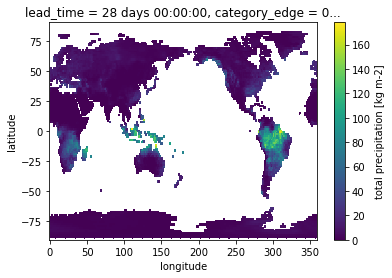

In [51]:
teb.isel(category_edge=0,forecast_time=2,lead_time=1).tp.plot()

In [22]:
obs_2000_2019_p = make_probabilistic(obs_2000_2019, tercile_edges, mask=mask)

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/xarray/core/accessor_dt.py:381: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,


In [23]:
obs_2000_2019_p.nbytes/1e6, 'MB'

(2955.147368, 'MB')

In [27]:
obs_2000_2019_p.chunk('auto').to_zarr(f'{cache_path}/hindcast-like-observations_2000_2019_biweekly_terciled.zarr', consolidated=True, mode='w')

/work/mh0727/m300524/conda-envs/s2s-ai/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
# forecast-like-observations terciled
# run renku commands from projects root directory only
# !renku dataset add --create hindcast-like-observations_2000_2019_biweekly_terciled data/hindcast-like-observations_2000_2019_biweekly_terciled.zarr

In [22]:
# to use retrieve from git lfs
#!renku storage pull ../data/hindcast-like-observations_2000_2019_biweekly_terciled.zarr
xr.open_zarr("../data/hindcast-like-observations_2000_2019_biweekly_terciled.zarr")

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 53, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] ...
  * category       (category) object 'below normal' 'normal' 'above normal'
Data variables:
    t2m            (category, lead_time, forecast_time, latitude, longitude) float64 ...
    tp             (category, lead_time, forecast_time, latitude, longitude) float64 ...

# benchmark

todo:
- get both variables
- rename if needed
- get both weeks
- have date and not weeks

In [26]:
bench = cml.load_dataset("s2s-ai-challenge-test-output-benchmark",
                         parameter='t2p', 
                         weeks='34'
                       ).to_xarray()

bench = bench.rename({'realization':'category', 't2p':'t2m'}) / 100
bench

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data. 


<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 53, latitude: 121, lead_time: 1, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * category       (category) int64 1 2 3
  * lead_time      (lead_time) timedelta64[ns] 28 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] ...
Data variables:
    t2m            (category, forecast_time, lead_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-17T16:01 GRIB to CDM+CF via cfgrib-0.9.9...

In [ ]:
# renku dataset